In [1]:
import numpy as np
from PIL import Image, ImageFilter
from timeit import default_timer as timer
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import subprocess as sp
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import glob

In [2]:
meet_bar = Image.open("meet_bar.png")
meet_np = np.array(meet_bar)

def detect_vi(img=None):
    global meet_bar, meet_np
    
    blur = False
    half = False
    
    
    wi, we, wh = 0, 960, 490 #width_ini, width_end, width_half
    hi, he = 150, 160        #height_ini, height_end
    thresh = 100 #30         #threshold for image difference
    
    whr = wh+150             #space to avoid popup of late participants (right)
    whl = wh-250             #space to avoid popup of late participants (left)
    
    #if(mean_squared_error(img[hi:he, wh+s:wh+s+20, :], meet_np) <= thresh): #right
    #if(mean_squared_error(img[hi:he, wh-s:wh-s+20, :], meet_np) <= thresh): #left
    
    if(img[hi:he, whr:whr+20, :].mean() <= thresh): #right
        if(img[hi:he, whl:whl+20, :].mean() <= thresh): #left
            blur = True
        else:
            wi = wh
            half, blur = True, True
            
    elif(img[hi:he, whl:whl+20, :].mean() <= thresh): #left
        half, blur = True, True
    #else:
        #default options (already set)
    
    if(blur):
        #print('blur image')
        
        if(half):
            we = wi + (470 if wi > 0 else 500) #width_end = width_half
            
            pil_im = Image.fromarray(img[:, wi:we, :])
            filter_im = pil_im.filter(ImageFilter.GaussianBlur(radius = 5))
            
            #right half of the screen
            if(wi > 0):
                pil_ini = Image.fromarray(img[:, :wi, :])
                filter_im = np.concatenate((pil_ini, filter_im), axis=1)
        else:
            pil_im = Image.fromarray(img[:, wi:we, :])
            filter_im = pil_im.filter(ImageFilter.GaussianBlur(radius = 5))           
        
        out_im = np.concatenate((filter_im , img[:, we:, :]), axis=1)
        return out_im 
    else:
        #print('not blur image', diff_min)
        return img

def plot_frame(frame):
    plt.figure(figsize=(20, 12))
    plt.imshow(frame)
    plt.grid(False)
    plt.show()
    
def cut_frame(frame):
    return frame[150:160, 600:620,:]

def calcula_diffs(frame_ini=0, frame_end=100, idx_meet_np = 0):
    global meet_bars, meet_nps
    
    for i in range(frame_ini, frame_end):
        frame = clip1.get_frame(i)
        diff = meet_nps[idx_meet_np] - cut_frame(frame)
        print(i, np.average(diff))

In [8]:
#carrega video a ser editado
video_file = 'reduc_dimens.mp4'
video_path = 'original/{}'.format(video_file)
print(video_path)

clip1 = VideoFileClip(video_path)
tempo_vi = int(clip1.duration)
print('Tempo vídeo:', tempo_vi)

original/reduc_dimens.mp4
Tempo vídeo: 4674


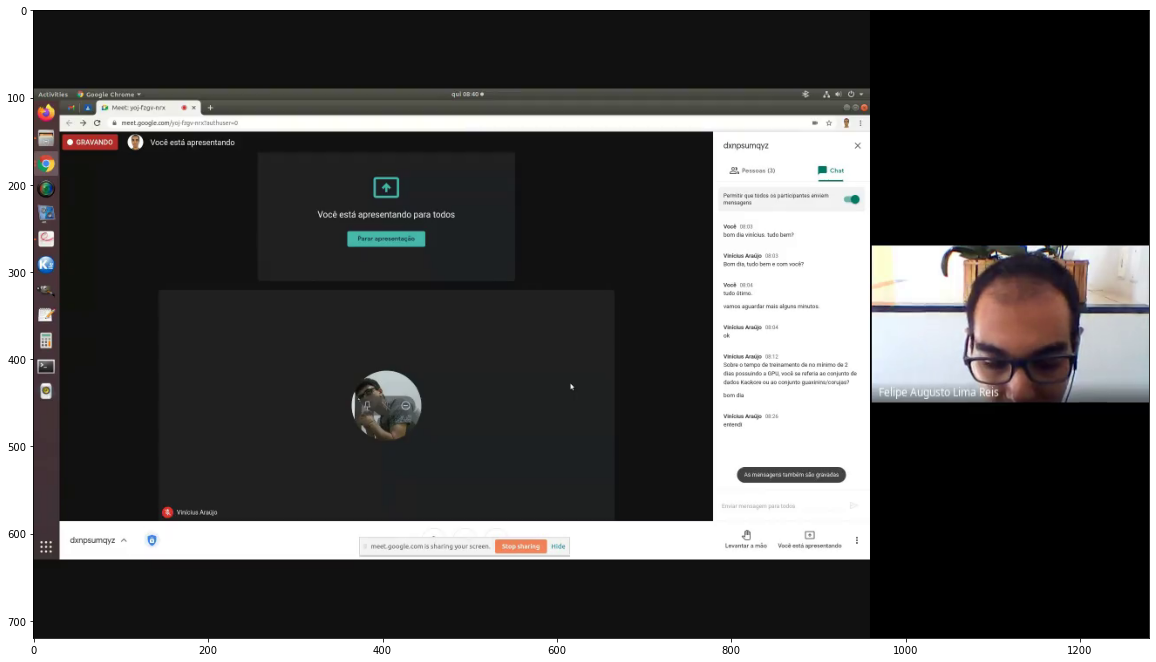

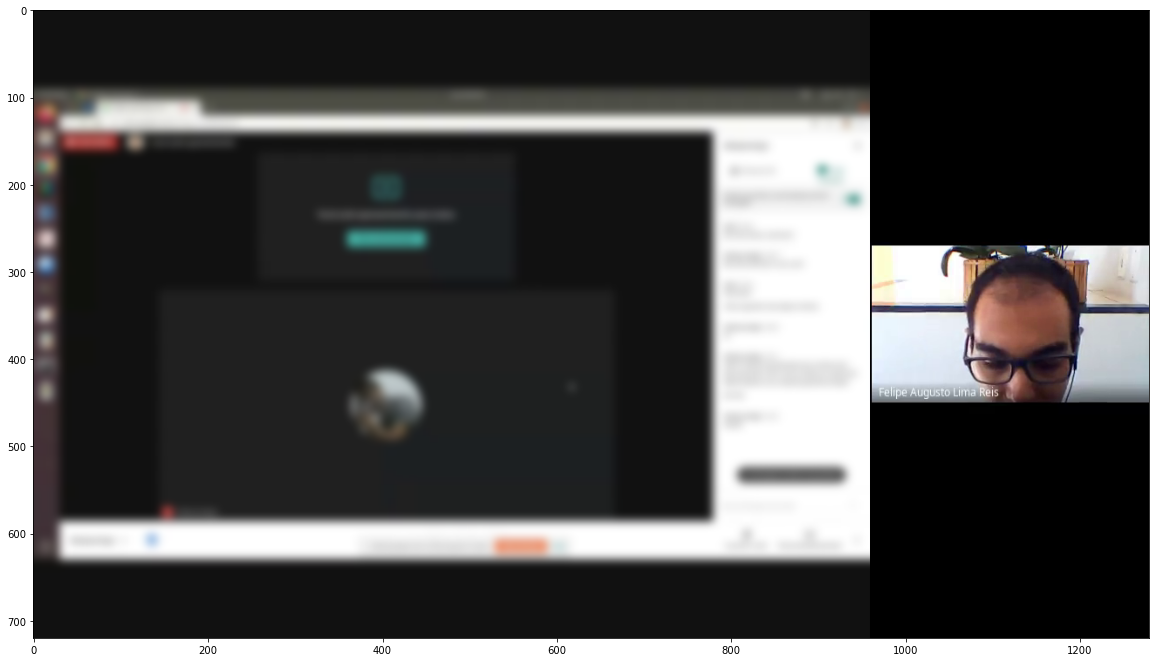

In [9]:
#exibe uma amostra da tela, para identificação prévia e testes iniciais
frame = clip1.get_frame(3) #ajg-sadx-pga => 3, 19, 64, 83.15, 200, 2857, 5795
output = detect_vi(img=frame)
plot_frame(frame)
plot_frame(output)

In [10]:
#test some samples (visual assert)
file_list = glob.glob("samples/*.png")
for file in file_list:
    sample = Image.open(file)
    s_arr = np.array(sample)
    output = detect_vi(img=s_arr)
    #plot_frame(output)

In [11]:
moviepy_folder = 'temp/'
moviepy_videofile = 'blur_{}'.format(video_file)
moviepy_audiofile = 'blur_{}m4a'.format(video_file[:-3])

print((moviepy_folder + moviepy_videofile))

#gera o vídeo
#blur_clip = clip1.subclip(1,15).fl_image(detect_vi)
blur_clip = clip1.fl_image(detect_vi)
blur_clip.write_videofile((moviepy_folder + moviepy_videofile), 
                          codec='libx264', 
                          audio_codec='aac', 
                          temp_audiofile=(moviepy_folder + moviepy_audiofile), 
                          remove_temp=False
)

chunk:   0%|          | 0/103065 [00:00<?, ?it/s, now=None]

temp/blur_reduc_dimens.mp4
Moviepy - Building video temp/blur_reduc_dimens.mp4.
MoviePy - Writing audio in temp/blur_reduc_dimens.m4a


t:   0%|          | 4/112553 [00:00<49:55, 37.57it/s, now=None]           

MoviePy - Done.
Moviepy - Writing video temp/blur_reduc_dimens.mp4



Moviepy - Done !
Moviepy - video ready temp/blur_reduc_dimens.mp4


In [13]:
#adiciona audio usando ffmpeg
command = ['ffmpeg',
           '-y', #approve output file overwite
           '-i', str(moviepy_folder + moviepy_videofile),
           '-i', str(moviepy_folder + moviepy_audiofile),
           '-c:v', 'copy',
           '-c:a', 'copy',
           '-shortest', 
           str('{}final_{}'.format(moviepy_folder, moviepy_videofile)) ]

#with open(ffmpeg_log, 'w') as f:
process = sp.Popen(command)